In [20]:
import getpass
import os

os.environ["COHERE_API_KEY"] = getpass.getpass()

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_cohere import ChatCohere, create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import AgentExecutor

model = ChatCohere()

os.environ["TAVILY_API_KEY"] = getpass.getpass()  

internet_search = TavilySearchResults(max_results=1)

internet_search.name = "internet_search"
internet_search.description = "Route a user query to the internet"

In [ ]:
## openAI
# nt9wg84wNjGfVEwC9ysQuAVdEJlT9bDYjtMeMA8g

## travily
# tvly-dev-9L3Bb43AfDd2Ycm4fVYo

![Screenshot from 2025-07-18 20-29-31.png](<attachment:Screenshot from 2025-07-18 20-29-31.png>)
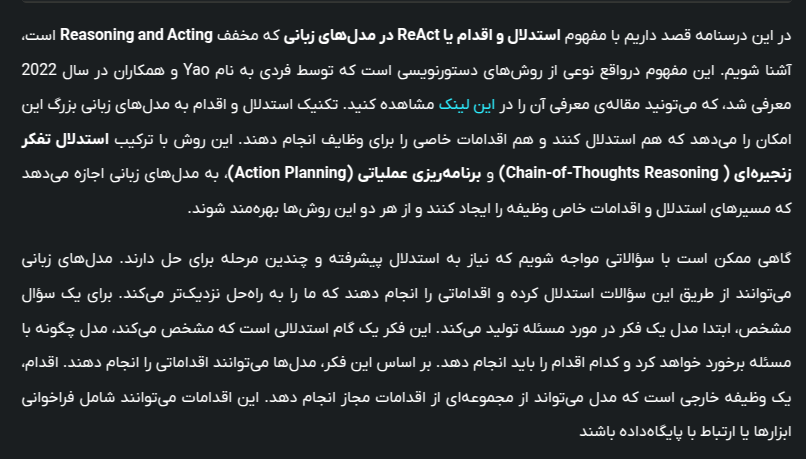

![Screenshot from 2025-07-18 20-30-03.png](<attachment:Screenshot from 2025-07-18 20-30-03.png>)
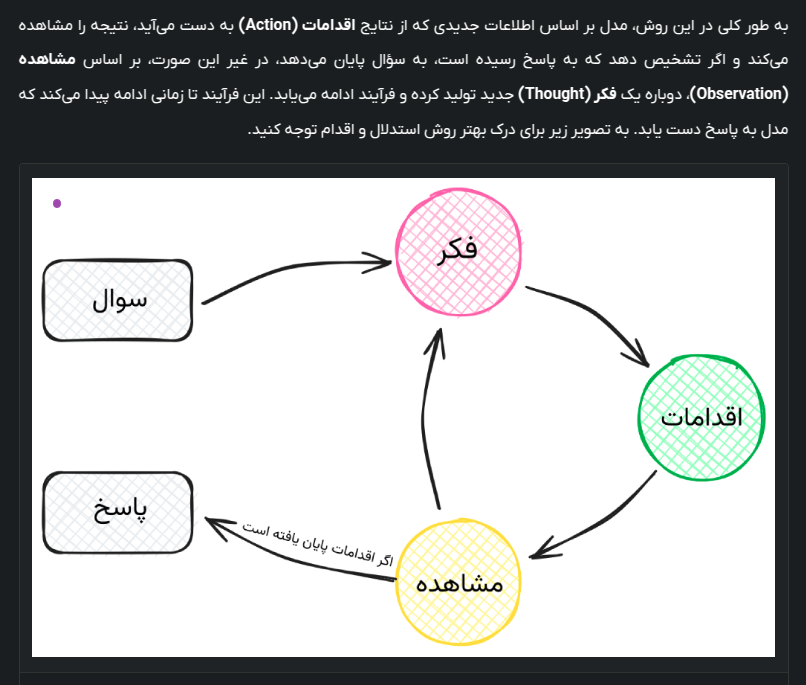

In [23]:
from langchain_experimental.utilities import PythonREPL
from langchain.agents import Tool

python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)

from pydantic import BaseModel, Field

repl_tool.name = "python_interpreter"

class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")
repl_tool.args_schema = ToolInput

In [25]:
# prompt = ChatPromptTemplate.from_template("{input}")
# prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are an assistant that solves problems using tools. "
#                "Always output tool actions as JSON inside a markdown code block like ```json ... ```"),
#     ("user", "{input}")
# ])

prompt = ChatPromptTemplate.from_messages([
    ("system", 
     "You are an assistant that solves problems using tools. "
     "Output *only* tool actions as JSON inside a markdown code block like ```json ... ```. "
     "For example:\n"
     "```json\n"
     "{\n"
     "  \"tool_name\": \"internet_search\",\n"
     "  \"parameters\": {\"query\": \"example query\"}\n"
     "}\n"
     "```"
    ),
    ("user", "{input}"),
    ("assistant", "{agent_scratchpad}")  # This is just an example; adjust based on agent's expectations.
])


agent = create_cohere_react_agent(
    llm=model,
    tools=[internet_search, repl_tool],
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=agent, tools=[internet_search, repl_tool], verbose=True)

agent_executor.invoke({
    "input": "Create a plot of the number of full time employees at the 3 tech companies with the highest market cap in the United States in 2024.",
})



> Entering new AgentExecutor chain...


KeyError: 'Input to ChatPromptTemplate is missing variables {\'\\n  "tool_name"\'}.  Expected: [\'\\n  "tool_name"\', \'agent_scratchpad\', \'input\'] Received: [\'input\', \'intermediate_steps\', \'agent_scratchpad\']\nNote: if you intended {\n  "tool_name"} to be part of the string and not a variable, please escape it with double curly braces like: \'{{\n  "tool_name"}}\'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT '

In [4]:
agent_executor.invoke({
    "input": "Hey how are you?",
})



> Entering new AgentExecutor chain...

I will respond to the user's greeting.
{'tool_name': 'directly_answer', 'parameters': {}}
directly_answer is not a valid tool, try one of [internet_search, python_interpreter].Relevant Documents: None
Cited Documents: None
Answer: I'm an AI model, so I don't have feelings as such, but I'm functioning as intended. How can I help?
Grounded answer: I'm an AI model, so I don't have feelings as such, but I'm functioning as intended. How can I help?

> Finished chain.


{'input': 'Hey how are you?',
 'output': "I'm an AI model, so I don't have feelings as such, but I'm functioning as intended. How can I help?",
 'citations': []}

In [17]:
from langchain_experimental.utilities import PythonREPL
from langchain.agents import Tool
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
# from langchain_cohere.react_multi_hop.output_parser import CohereToolsReactAgentOutputParser
from langchain_core.runnables import RunnableConfig
from langchain_cohere import ChatCohere  # Or use any chat model

# --- 1. Define the Python tool ---
python_repl = PythonREPL()

class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")

repl_tool = Tool(
    name="python_interpreter",
    description="Executes Python code and returns the result.",
    func=python_repl.run,
    args_schema=ToolInput
)

# --- 2. Setup the LLM (Cohere, with low temperature) ---
llm = ChatCohere(model="command-r-plus", temperature=0)

# --- 3. Prompt template to force proper output format ---
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an agent that uses tools to solve problems. "
               "Always return tool calls in a markdown block like:\n"
               "```json\n"
               "{\"tool_name\": \"tool_name_here\", \"parameters\": {\"key\": \"value\"}}\n"
               "```\n"
               "Only respond with a Plan and one JSON tool action."),
    ("user", "{input}")
])

# --- 4. Create the agent ---
agent = create_cohere_react_agent(
    llm=llm,
    tools=[repl_tool],
    prompt=prompt
)

# --- 5. Invoke the agent ---
config = RunnableConfig()
result = agent.invoke({"input": "What is 2 + 3 * 4 in Python?"})#, config=config)

print(result)


KeyError: 'Input to ChatPromptTemplate is missing variables {\'"tool_name"\'}.  Expected: [\'"tool_name"\', \'input\'] Received: [\'input\', \'agent_scratchpad\']\nNote: if you intended {"tool_name"} to be part of the string and not a variable, please escape it with double curly braces like: \'{{"tool_name"}}\'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT '